# Tutorial: Entendimiento de los datos con PySpark

## Introducción
    ¿Qué aprenderá? 
    En este tutorial aprenderá cómo puede realizar el entendimiento de los datos en el contexto de un proyecto de analítica. A nivel de la metodología ASUM-DM estamos en la fase de entendimiento de datos y en la arquitectura nos encontramos trabajando con el componente de fuentes de datos.

    ¿Qué construirá? 
    En este tutorial realizará la exploración o perfilamiento de un conjunto de datos provenientes de una base de datos relacional, al igual que un análisis de la calidad de los datos utilizando los DataFrames de PySpark. Además, generará las conclusiones requeridas para ser compartidas en reuniones y formalizadas en la documentación del proyecto. Las conclusiones son variadas pero en general podemos decir que siempre deberían incluir una lista de preguntas o aclaraciones para la organización, conclusiones de los datos/problemas de calidad y alternativas para la limpieza. Un entendimiento de datos sin conclusiones no es útil y tampoco es entendible para personas de negocio.
    
    ¿Para qué?
    Antes de realizar cualquier tipo de proyecto de datos es necesario entender los datos con unas tareas de exploración o perfilamiento de datos y de análisis de calidad. Esta fase de la metodología permite determinar si es posible o no realizar el proyecto dada la cantidad y calidad de los datos, el tiempo requerido para su preparación y las diferentes actividades que se requieren para mejorar los datos en caso de requerirse.  
    
    ¿Qué necesita?
    Los siguientes requisitos se encuentran instalados en la máquina virtual asignada a cada estudiante, específicamente en el ambiente de anaconda llamado "Tutoriales". Recuerde que tiene a su disposición el tutorial de conexión a máquinas virtuales en la semana 1 de Coursera
    1. Python 3 con pip instalado
    2. Jupyter Labs
    3. Paquetes: Pyspark (3.2.1), pandas (1.2.1), numpy (1.20.0) y matplotlib (3.3.4)
    Otros:
    1. Controlador Connector J(ya se encuentra configurado)
    2. Acceso a servidor remoto MySQL con base de datos relacional "WWImportersTransactional". Recuerde que tiene a su disposición el tutorial de conexión remoto a Mysql en la semana 1 de Coursera


Continuando con el proyecto de consultoria de Wide World Importers, el primer paso para iniciar la comprensión de los datos es explorar y entender las fuentes de datos disponibles. Note que esto también nos ayuda a comprender mejor la organización.

## Configuración e importe de paquetes
Se utilizará el paquete de pandas profiling para apoyar el análisis estadístico, y se importan los paquetes de python
necesarios

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
#import matplotlib.pyplot as plt
import numpy as np

In [2]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

Configuración del controlador e inicio de sesion Spark

In [3]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [4]:
# Si quiere practicar la conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://157.253.236.116:8080/ProyectoTransaccional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = 'Estudiante_68_202314'
db_psswd = 'aabb1122'

PATH='./'

## Perfilamiento de los datos
El perfilamiento se basa en varios aspectos: **entendimiento general** de los datos compartidos, validación de **reglas de negocio**, **análisis descriptivo** utilizando estadística descriptiva y diagramas para la visualización de los datos y **análisis de calidad**. El primero hace referencia a tener una comprensiòn global antes de entrar en los detalles, la segunda sobre las reglas, corresponden a especificaciones dadas por el negocio en relación con los datos, un ejemplo de regla de negocio dada es: "Todo producto de la canasta familiar debe tener un precio de IVA equivalente a 19%", dada esta regla de negocio, se debe revisar en los datos suministrados que no hayan valores de IVA menores a 19%. En el tercer aspecto, relacionado con el análisis descriptivo, se revisan estadísticas: mínimo, máximo, media, mediana, distribuciones de los datos, valores nulos, cardinalidad con el fin de comprender en mayor nivel de profundidad los datos compartidos.


### Información dada por la organización relacionada con los datos
Los datos compartidos por la empresa son registros de vuelos, aeropuertos, información de centros poblados (concentración de mínimo 20 viviendas contiguas) donde el negocio asume que un aeropuerto está asignado a un centro poblado, un centro poblado solo puede estar en un municipio, información de proyección de poblacion y de PIB por departamentos. Dichos datos pueden tener errores ya que no han sido utilizados previamente para ser analizados. Con respecto a los datos, la empresa nos comentan lo siguiente:

- Hay informacion del PIB para los 32 departamentos desde 2005 hasta 2018
- Se tiene la información de proyecciones de vida por género y edad para los 32 departamentos desde 2005 hasta 2015
- El total de hombres de valle del cauca para 2014 es 2110069
- Hay información de 605.448 vuelos entre 2004 y 2018 y de 865 aeropuertos construidos desde 2013 hasta 2020
- Hay información de 7879 centros poblados

### Conexión a fuente de datos y acceso a los datos

#### Conexión a fuente de datos
A continuación encuentra las funciones para conectarse a la fuente de datos (archivo csv o base de datos) y retornar un dataframe que es el que se utilizará posteriormente para manipular los datos.

In [5]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

#### Cargue de datos
Para consultar desde la base de datos se puede acceder directamente a la tabla dado su nombre o se puede especificar la sentencia SQL de un "SELECT" completo para traer la información total o parcial de la tabla que se requiere. A continuación un ejemplo de cada uno de estos usos. 
Acceso directo para el caso de órdenes y acceso con sentencia SQL para el caso de detallesOrdenes.

In [6]:
sql_aeropuertos = 'ProyectoTransaccional.aeropuertosCopia'

In [7]:
#Se cargan los dataframes desde la base de datos
aeropuertos = obtener_dataframe_de_bd(db_connection_string, sql_aeropuertos, db_user, db_psswd)

### Entendimiento general de datos

Para ver una muestra de los datos, utilice el comando <i>show</i> ingresando el número de filas que quiere ver

In [8]:
aeropuertos.show(5)

+-----+----+--------------------+--------------------+------------+----------+-------+--------+-----------------+--------------------+--------------+-----------+------+-----------+---------+----------+------------------+--------------+-----+--------+--------------------+----------------+-------------+
|sigla|iata|              nombre|           municipio|departamento| categoria|latitud|longitud|      propietario|          explotador|longitud_pista|ancho_pista|  pbmo|orientacion|elevacion|resolucion|fecha_construccion|fecha_vigencia|clase|    tipo|numero_vuelos_origen|gcd_departamento|gcd_municipio|
+-----+----+--------------------+--------------------+------------+----------+-------+--------+-----------------+--------------------+--------------+-----------+------+-----------+---------+----------+------------------+--------------+-----+--------+--------------------+----------------+-------------+
|  9cg|    |san jose del ariporo|      Paz de Ariporo|    casanare|AerÃ³dromo|    500|-70.0

Como puede observar en la tabla de aeropuertosCopia tenemos información **relacionada con los aeropuertos de los diferentes departamentos del país, la sigla que los identifica y toda la información relacionada con cada uno de ellos**. La información del propietario, esto es si el dueño es el departamento, el municipio, etc. También encontramos información relacionada en cuanto al tipo de aeropuerto; es decir, si es público o privado, de que categoría es, teniendo en cuenta que existe una categorización para cada uno de ellos. Otra información que se encuentra almacenada en esta tabla es la relacionada a su ubicación geografica, departamento, municipio. El número de vuelos que salen de cada uno de estos aeropuertos.

In [9]:
aeropuertos.schema

StructType(List(StructField(sigla,StringType,true),StructField(iata,StringType,true),StructField(nombre,StringType,true),StructField(municipio,StringType,true),StructField(departamento,StringType,true),StructField(categoria,StringType,true),StructField(latitud,IntegerType,true),StructField(longitud,StringType,true),StructField(propietario,StringType,true),StructField(explotador,StringType,true),StructField(longitud_pista,IntegerType,true),StructField(ancho_pista,DoubleType,true),StructField(pbmo,StringType,true),StructField(orientacion,StringType,true),StructField(elevacion,StringType,true),StructField(resolucion,StringType,true),StructField(fecha_construccion,StringType,true),StructField(fecha_vigencia,StringType,true),StructField(clase,StringType,true),StructField(tipo,StringType,true),StructField(numero_vuelos_origen,DoubleType,true),StructField(gcd_departamento,IntegerType,true),StructField(gcd_municipio,IntegerType,true)))

Por otra parte, se puede ver que cuenta con 17 campos de tipo String, se tienen 2 campos de tipo Double y 4 campos de tipo entdero. El identificador del aeropuerto es la sigla. Una primera aclaración a solicitar por parte del negocio es que información almacenan los campos "iata" y "pbmo" y si es posible eliminarlos ya que existen varios registros vacios.

**¿Qué es una fila de cada fuente compartida?**
Con estos análisis podemos concluir que una fila de la tabla aeropuertosCopia representa la información relacionada con los aeropuertos que se encuentran en los diferentes municipios del país, del tipo que son estos aeropuertos y la ubicación geografica de cada uno de ellos.

Una vez entendida en términos generales la estructura de los datos, es necesario conocer la cantidad de datos disponibles, esto se hace con count() y con columns, que retornan el número de filas y número de columnas respectivamente.

In [10]:
print((aeropuertos.count(), len(aeropuertos.columns)))

(547, 23)


**¿Cuantos datos nos compartieron para el proyecto?**
En total tenemos 547 registros de aeropuertos y tenemos en total 23 variables a revisar de las cuales 17 son de cadenas de caracteres y las restantes 6 son numéricas, de esas 6 dos son de tipo Double y las demás son enteras. Acá tenemos una conclusión ya que el negocio nos manifestó que se contaba con 865 aeropuertos, pero esta información no es cierta.

### Revisión de reglas de negocio 

Primero se confirman las reglas proporcionadas por el negocio, para la tabla de aeropuertosCopia se asegura que hay información de 605.448 vuelos entre 2004 y 2018 y de 865 aeropuertos construidos desde 2013 hasta 2020

In [24]:
print((aeropuertos.select("numero_vuelos_origen").count()))
aeropuertos.select("nombre").distinct().show()
print(aeropuertos.select("numero_vuelos_origen").distinct().show())

547
+--------------------+
|              nombre|
+--------------------+
|       santa rosalia|
|        san jeronimo|
|           araguaney|
|jorge e. gonzalez t.|
|       puerto gaitan|
|      chicoral estra|
|   hato la esperanza|
|              julian|
|     gemelos dorados|
|            san luis|
|        el lago - ca|
|          vanguardia|
|              falcon|
|             sirenas|
|           la aurora|
|san felipe del pauto|
|              mutata|
|       nueva fortuna|
|    las violetas- ca|
|          los guires|
+--------------------+
only showing top 20 rows

+--------------------+
|numero_vuelos_origen|
+--------------------+
|              -924.0|
|               147.0|
|                 8.0|
|                70.0|
|             -4108.0|
|                 0.0|
|                69.0|
|              -313.0|
|              2143.0|
|               -52.0|
|             -1754.0|
|                -5.0|
|               -50.0|
|              -376.0|
|              -257.0|
|   

Con las anteriores consultas podemos ver que esta regla no es cierta ya que no existen 865 aeropuertos, solo existen 547. Esta información se debe entregar en las conclusiones al negocio. Por otra parte se debe pedir la aclaración del porque en la cantidad de numero_vuelos_origen se tiene información negativa. Se puede arreglar este valor filtrando los registros negativos y multiplicandolos por -1 para dejarelos positivos.

In [27]:
aeropuertos.groupBy("municipio").count().show()

+--------------------+-----+
|           municipio|count|
+--------------------+-----+
|             Condoto|    2|
|             Palermo|    3|
|           El Espino|    1|
|       Fuente de Oro|    9|
|        Bugalagrande|    1|
|   VigÃ­a del Fuerte|    2|
|          Villanueva|    9|
|              Amalfi|    1|
|San Luis de Palenque|    4|
|            CiÃ©naga|    3|
|           Rioblanco|    1|
|           Papunahua|    1|
|            San Luis|    2|
|           El Charco|    1|
|           ApartadÃ³|    1|
|               Pasto|    1|
|            Trinidad|    7|
|          Candelaria|    2|
|  San Juan del Cesar|    2|
|               Neiva|    1|
+--------------------+-----+
only showing top 20 rows



Si se quiere saber cuántos registros hay por cada valor posible, existen varias formas de hacerlo, en la siguiente celda se muestra cómo iterar sobre los valores resultado de una consulta y cómo filtrar el número de registros para cada valor usando filter y select where, también se da un ejemplo de uso de group by y agregaciones

Pyspark tiene funcionalidades de los DataFrames que permiten explorar los datos por medio de agregaciones y estas funcionan similar a como se usan en SQL

Primero, se debe agrupar sobre una columna con el método <i>groupBy</i> y después se pueden realizar agregaciones sobre otras columnas con el método <i>agg</i>. La sintaxis es la siguiente: 
 ``` 
    DataFrame.groupBy('COLUMN NAME').agg({'COLUMN NAME 1': 'mean', 'COLUMN NAME 2': 'count', 'COLUMN NAME 3': 'max'})
  ``` 

En cualquiera de los 3 casos se observa que el resultado es el mismo

In [35]:

aeropuertos.groupBy("numero_vuelos_origen").count().show()
aeropuertos.select(sum(aeropuertos["numero_vuelos_origen"])).show()

+--------------------+-----+
|numero_vuelos_origen|count|
+--------------------+-----+
|              -924.0|    2|
|               147.0|    1|
|                 8.0|    3|
|                70.0|    1|
|             -4108.0|    1|
|                 0.0|   92|
|                69.0|    1|
|              -313.0|    1|
|              2143.0|    1|
|               -52.0|    1|
|             -1754.0|    2|
|                -5.0|   12|
|               -50.0|    2|
|              -376.0|    2|
|              -257.0|    1|
|              6784.0|    1|
|              -134.0|    1|
|                -2.0|   22|
|            -15994.0|    1|
|              -658.0|    1|
+--------------------+-----+
only showing top 20 rows



TypeError: Column is not iterable

La conclusión es entonces que la regla no es completamente cierta, pues en la cantidad de datos no existe la cantidad de aeropuertos que informagocio, es necesario pedir aclaraciones al negocio en relación a este descubrimiento. Al contar con valores negativos no es posible determinar con exactitud la cantidad de vuelos que informa el negocio, para esto sería necesario realizar el cambio a valores positivos, claro esta que con la aclaración del porque existen valores negativos para este campo.

In [36]:
aeropuertos.distinct().count()

444

Como pueden ver hay 444 aeropuertos únicos. Es decir que sabemos que hay 123 aeropuertos completamente repetidos, esto sigue siendo una conclusión para que negocio lo aclare.

In [39]:
aeropuertos.select(col('nombre')).distinct().count()

413

De esta manera vemos que hay una diferencia de 154 registros cuyo identificador es el mismo.

Lo siguiente es verificar las fechas en los datos, nos dicen hay información de 605.448 vuelos entre 2004 y 2018 

In [41]:
aeropuertos.agg({"fecha_vigencia": "min"}).show()

+-------------------+
|min(fecha_vigencia)|
+-------------------+
|                   |
+-------------------+



como se ve en la anterior consulta no contamos con una fecha minima en el campo vigencia que se entiende es la fecha desde que esta en operación el aeropuerto. Es necesario informar de este hallazgo al negocio o pedir aclaración ya que no se sabe si este es el campo que almacena la información de inicio de operación del aeropuerto.

La siguiente regla nos indica que es necesario revisar el formato de las fechas YYYY-MM-DD HH:MM:SS, un ejemplo es el atributo <i>fecha_construccion</i> y el campo <i>fecha_vigencia</i>. Para esto vamos a hacer uso de expresiones regulares, que son patrones de búsqueda, en este caso queremos 4 dígitos entre 0 y 9 que indican el año seguido del símbolo - luego tenemos un número de 2 dígitos que puede empezar con 0 seguido de un número entre 1 y 9 (meses 01 hasta 09) o 1 seguido de 1 o 2 (meses 11 o 12), sigue otro -, y terminamos con un número de 2 dígitos que van desde el día 01 hasta el 31, se usa rlike smilar a LIKE de SQL

In [44]:
regex = "[0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])"
cumplenFormato = aeropuertos.filter(aeropuertos["fecha_construccion"].rlike(regex))
print("Número total de aeropuertos: "+str(aeropuertos.count())+", número de fechas con formato correcto en la fecha de construcción: "+str(cumplenFormato.count()))

regex = "[0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])"
cumplenFormato = aeropuertos.filter(aeropuertos["fecha_vigencia"].rlike(regex))
print("Número total de aeropuertos: "+str(aeropuertos.count())+", número de fechas con formato correcto en la fecha de vigencia: "+str(cumplenFormato.count()))

Número total de aeropuertos: 547, número de fechas con formato correcto en la fecha de construcción: 164
Número total de aeropuertos: 547, número de fechas con formato correcto en la fecha de vigencia: 87


Para ver los registros que no cumplen con el formato podemos negar la condición del filtro con el símbolo ~ al principio:

In [45]:
noCumplenFormato = aeropuertos.filter(~aeropuertos["fecha_construccion"].rlike(regex))
noCumplenFormato.count(), noCumplenFormato.select(col("fecha_construccion")).show()

+------------------+
|fecha_construccion|
+------------------+
|                  |
|                  |
|                  |
|                  |
|                  |
|                  |
|                  |
|                  |
|                  |
|                  |
|                  |
|                  |
|                  |
|                  |
|                  |
|                  |
|                  |
|                  |
|                  |
|                  |
+------------------+
only showing top 20 rows



(383, None)

In [46]:
noCumplenFormato = aeropuertos.filter(~aeropuertos["fecha_vigencia"].rlike(regex))
noCumplenFormato.count(), noCumplenFormato.select(col("fecha_vigencia")).show()

+--------------+
|fecha_vigencia|
+--------------+
|              |
|              |
|              |
|              |
|              |
|              |
|              |
|              |
|              |
|              |
|              |
|              |
|              |
|              |
|              |
|              |
|              |
|              |
|              |
|              |
+--------------+
only showing top 20 rows



(460, None)

Concluimos entonces, que hay 383 registros cuya fecha de construcción y 460 en el campo de fecha de vigencia que no cumplen con el formato especificado. Se debe solicitar una aclaración de parte de negocio para saber si es mejor eliminar el campo o llenar con alguna fecha por defecto.

Para facilitar los análisis y evitar inconsistencias o conclusiones erradas vamos a estandarizar los datos, en este caso las fechas. Sin embargo, esta actividad puede hacerse sobre formatos de números, texto entre otras. 

Algo que se debe tener en cuenta en el perfilamiento de reglas de negocio es que dichas reglas pueden estar incompletas, por ende se recomienda tener especial cuidado con las columnas tipo caracter o string dado que suelen ser pasadas por alto en el análisis estadistico, un ejemplo es la columna **Descripcion**, al ser una columna de descripción del producto se espera que tenga un cierto número de caracteres. Sin embargo haciendo la validación vemos que algunas descripciones son textos incompletos como "a". Este podría llegar a ser un problema a futuro por lo que se decide notificar a la organización.

In [53]:
aeropuertos.where(length(col("categoria")) <= 1).show()

+-----+----+--------------------+--------------------+------------------+---------+-------+--------+--------------------+--------------------+--------------+-----------+-------+-----------+---------+----------+------------------+--------------+-----+---------+--------------------+----------------+-------------+
|sigla|iata|              nombre|           municipio|      departamento|categoria|latitud|longitud|         propietario|          explotador|longitud_pista|ancho_pista|   pbmo|orientacion|elevacion|resolucion|fecha_construccion|fecha_vigencia|clase|     tipo|numero_vuelos_origen|gcd_departamento|gcd_municipio|
+-----+----+--------------------+--------------------+------------------+---------+-------+--------+--------------------+--------------------+--------------+-----------+-------+-----------+---------+----------+------------------+--------------+-----+---------+--------------------+----------------+-------------+
|  pbo|    |      puerto bolivar|              Uribia|       

Se debe informar al negocio que el campo categoria tiene información con longitud menor a 1 y en muchos casos en blanco, esto podría dificultar una consulta de cantidad de vuelos por categoria, si es que el negocio llega a requerirlo.

### Análisis descriptivo
Una vez cubierto lo básico de reglas de negocio, pasamos a perfilamiento estadístico. Para ver estadisticos generales como conteo, mínimo, máximo, desviación estandar y percentiles utilice summary()

In [54]:
aeropuertos.summary().show()

+-------+-----+----+--------+---------+------------+----------+-------+------------------+--------------------+-------------+--------------+------------------+------------------+-----------+------------------+----------+------------------+--------------+------------------+--------+--------------------+------------------+-----------------+
|summary|sigla|iata|  nombre|municipio|departamento| categoria|latitud|          longitud|         propietario|   explotador|longitud_pista|       ancho_pista|              pbmo|orientacion|         elevacion|resolucion|fecha_construccion|fecha_vigencia|             clase|    tipo|numero_vuelos_origen|  gcd_departamento|    gcd_municipio|
+-------+-----+----+--------+---------+------------+----------+-------+------------------+--------------------+-------------+--------------+------------------+------------------+-----------+------------------+----------+------------------+--------------+------------------+--------+--------------------+---------------

En las estadísticas anteriores vemos que las columnas sigla, iata, nombre, municipio, departamento tienen el 75 percentil emn null, es decir son columnas vacías por lo que se pueden eliminar, también observamos el calculo de la media para las columnas ID, Se confirma que la fecha minima es 0, también la cantidad de vuelos es 0 y la máxima de 7439.

{'whiskers': [<matplotlib.lines.Line2D at 0x18680fd13c8>,
 'caps': [<matplotlib.lines.Line2D at 0x18680fe11c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x18680f50b88>],
 'medians': [<matplotlib.lines.Line2D at 0x18680fe5348>],
 'fliers': [<matplotlib.lines.Line2D at 0x18680fe1e08>],
 'means': []}

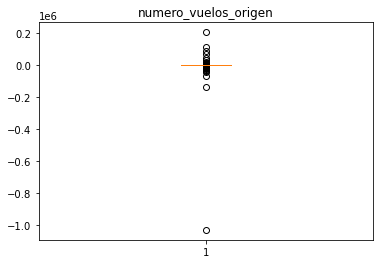

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('numero_vuelos_origen')
ax1.boxplot(np.array(aeropuertos.select('numero_vuelos_origen').collect()))

In [57]:
aeropuertos.groupby("departamento").count().orderBy("count", ascending=False).show(5)

+------------+-----+
|departamento|count|
+------------+-----+
|    casanare|  124|
|        meta|   89|
|      tolima|   44|
|      vaupes|   38|
|       cesar|   29|
+------------+-----+
only showing top 5 rows



## Análisis de calidad de datos
La calidad de los datos consiste en validar la idoneidad de los datos analizando varias dimensiones, entre las cuales resaltamos:
- Completitud: Datos que no existen o no se conocen
- Unicidad (Duplicidad): Datos que son idénticos en diferentes registros o registros con valores idénticos en atributos en los que no debería ocurrir
- Consistencia: Esta medida se define por la validez o integridad del dato, en la definición de su estructura, al interior de una fila o entre diferentes filas de la misma fuente o de diferentes fuentes. El manejo de unidades en los datos y el significado del dato son generadores de inconsistencias.
- Validez: a nivel de formato y de sentido de los datos más alla de sus valores

Para asegurar una calidad mínima de los datos en estas dimensiones hay que entender su origen y posteriormente realizar un proceso de validación de cada una de las dimensiones de perfilamiento que llevará a un entendimiento de los datos disponibles.


A continuación se definen dos funciones, la primera cuenta los valores vacios por columna de dataframe, la segunda retorna un diccionario de columnas con cardinalidad superior al 50%


### Unicidad y validez

La unicidad y la validez se revisaron al comprobar las reglas de negocio en análisis previos. 

### Completitud y validez

In [62]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(df[c].isNull()).count()
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados

def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

In [63]:
columnas_vacias_aeropuertos = contar_vacios(aeropuertos)
print('detalles de aeropuertos: ')

detalles de aeropuertos: 


In [64]:
columnas_alta_cardinalidad_aeropuertos = cardinalidad(aeropuertos)

En esta tabla tenemos varias celdas con con campos que se encuentran en null y otro que estan vacios. Por ejemplo en el códido iata, en el campo longitud, en el campo pmob y en los camos de fechas.

### Consistencia
A nivel de consistencia algunos ejemplos de revisión son precios negativos, en este caso tenemos la columna de numero_vuelos_origen que presenta valores en negativo. Otro campo es el campo municipio y categoría que presentaninformación incompleta y otros que alamcenan caracteres especiales que no debería esta allí.

## Herramientas para facilitar el entendimiento de datos

Algunas de las estadísticas antes desarrolladas pueden obtenerse por medio de herramientas como Pandas Profiling una herramienta muy útil, <b><i>Pero no perfecta ni completa</i></b>, es Pandas profiling que dado un conjunto de datos, nos muestra histogramas, estadísticas etc. A continuación guardamos el reporte en html

In [70]:
reporte = ProfileReport(aeropuertos.toPandas())
reporte.to_file(PATH+"reporte_prefilamiento_aeropuertos.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Lo primero que hay que notar es que hay 3 secciones principales. La primera es un resumen, la segunda es un análisis por cada variable y luego tenemos interacciones y correlaciones entre variables. 

Seccion general del reporte:
1. Tenemos 23 variables y 547 registros (es decir, aeropuerts), de las cuales 17 son Strings, 2 Double, 2 enteros (la herramienta entiende tipo de variable como tipo de dato, asi que la información que nos da no es necesariamente correcta en este aspecto).

2. En los datos hay 17.2% de datos vacíos, (conclusión)

3. El archivo ocupa en memoria 89.9 Kb

4. Hay 94 datos duplicados

Sección de variables del reporte:

5. Note que para cada variable sigla se tienen 443 registros únicos.


<b>Cabe aclarar que un pandas profiling sin interpretación no es suficiente como análisis para realizar el entendimiento de los datos.

Así mismo, recuerde que si es necesario, se debe utilizar otra herramienta (código, visualizaciones, etc) para poder completar el análisis estadístico.</b>

### Algunas gráficas utiles: Diagrama de caja, dispersion, histogramas para entender las distribuciones de las variables

Generalmente las gráficas se emplean para entender la distribución de cada variable, también sirven para visualizar la relación entre 2 o más variables

Algunas gráficas útiles son los histogramas, disepersión, diagramas de caja. Hay varias maneras de implementarlos, con paquetes como matplotlib o pandas, con funciones propias de pyspark, etc, a continuacón mostramos cómo hacerlo a travez de pandas

array([[<AxesSubplot:title={'center':'numero_vuelos_origen'}>]],
      dtype=object)

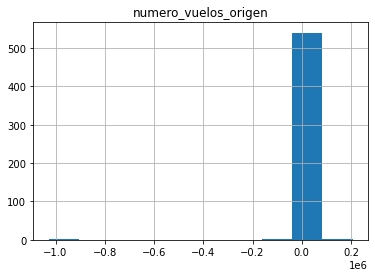

In [71]:
#para valores extremos(subir a calidad)
aeropuertos.toPandas().hist(column='numero_vuelos_origen')

In [74]:
cantidades = aeropuertos.groupby("departamento").count().orderBy("count", ascending=False)

Como se puede observar, el método retorna un dataframe, que vamos a usar para obtener dos arreglos, uno con el rango de cada una de las barras y otro con la cantidad de registros por rango. Se puede usar Matplotlib para graficar esta información:

In [75]:
def plotHistogramData(data):
    binSides, binCounts = [row[0] for row in data.collect()], [row[1] for row in data.collect()]
    binSides = [round(i, 2) for i in binSides]
    N = len(binCounts)
    ind = np.arange(N)
    width = 1

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind+0.5, binCounts, width, color='b')
    
    fig.set_size_inches(1.3*N, 8)

    ax.set_ylabel('Frecuencia')
    ax.set_xlabel('Rango')
    ax.set_title('Histograma')
    ax.set_xticks(np.arange(N))
    ax.set_xticklabels(binSides)

    plt.show()

plotHistogramData(cantidades)

TypeError: type str doesn't define __round__ method

El diagrama de dispersion, nos muestra los datos para dos variables en forma de puntos y es muy útil para entender la relación entre dichas variables

### Otras opciones de exploración
PySpark también da la opción de crear tablas de pivotes. En el siguiente ejemplo, se muestra cómo hacer una tabla que permite ver cuántas ordenes hay por cada <i>Fecha_de_pedido</i> y por cada <i>ID_de_vendedor</i>, es decir por fecha y por empleado cuantas ordenes existen:

In [76]:
aeropuertos.groupBy('Fecha_vigencia').pivot('departamento').count().show()

+--------------+--------+---------+------+---------+------------+-------+------+------+-------+--------+-----+-----+-----+-------+------------+-------+--------+-----+----------+---------+----+-------+------------------+--------+-------+---------+---------+-----+------+---------------+------+-------+
|Fecha_vigencia|amazonas|antioquia|arauca|atlantico|bogota, d.c.|bolivar|boyaca|caldas|caqueta|casanare|cauca|cesar|choco|cordoba|cundinamarca|guainia|guaviare|huila|la guajira|magdalena|meta|nariÃ±o|norte de santander|putumayo|quindio|risaralda|santander|sucre|tolima|valle del cauca|vaupes|vichada|
+--------------+--------+---------+------+---------+------------+-------+------+------+-------+--------+-----+-----+-----+-------+------------+-------+--------+-----+----------+---------+----+-------+------------------+--------+-------+---------+---------+-----+------+---------------+------+-------+
|    2016-08-08|    null|     null|  null|     null|        null|   null|  null|  null|   null|  

Lo anterior nos muestra que muchos de los campos se encuentran vacios.

In [77]:
corr = aeropuertos.toPandas().corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pandas\io\formats\style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pandas\io\formats\style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,latitud,longitud_pista,ancho_pista,numero_vuelos_origen,gcd_departamento,gcd_municipio
latitud,nan,nan,nan,nan,nan,nan
longitud_pista,nan,nan,nan,nan,nan,nan
ancho_pista,nan,nan,1.000000,-0.010465,-0.062686,-0.063421
numero_vuelos_origen,nan,nan,-0.010465,1.000000,0.092060,0.092734
gcd_departamento,nan,nan,-0.062686,0.092060,1.000000,0.999956
gcd_municipio,nan,nan,-0.063421,0.092734,0.999956,1.000000


## Conclusiones/resultados


**Conclusiones generales:**

1. Como puede observar en la tabla de aeropuertosCopia tenemos información relacionada con los aeropuertos de los diferentes departamentos del país, la sigla que los identifica y toda la información relacionada con cada uno de ellos. La información del propietario, esto es si el dueño es el departamento, el municipio, etc. También encontramos información relacionada en cuanto al tipo de aeropuerto; es decir, si es público o privado, de que categoría es, teniendo en cuenta que existe una categorización para cada uno de ellos. Otra información que se encuentra almacenada en esta tabla es la relacionada a su ubicación geografica, departamento, municipio. El número de vuelos que salen de cada uno de estos aeropuertos.

2. En total tenemos 547 registros de aeropuertos y tenemos en total 23 variables

3. Acá tenemos una conclusión ya que el negocio nos manifestó que se contaba con 865 aeropuertos, pero esta información no es cierta.

4. Concluimos entonces, que hay 383 registros cuya fecha de construcción y 460 en el campo de fecha de vigencia que no cumplen con el formato especificado. Se debe solicitar una aclaración de parte de negocio para saber si es mejor eliminar el campo o llenar con alguna fecha por defecto.

**Conclusiones de reglas de negocio:**

1. Con las anteriores consultas podemos ver que esta regla no es cierta ya que no existen 865 aeropuertos, solo existen 547. Esta información se debe entregar en las conclusiones al negocio. Por otra parte se debe pedir la aclaración del porque en la cantidad de numero_vuelos_origen se tiene información negativa. Se puede arreglar este valor filtrando los registros negativos y multiplicandolos por -1 para dejarelos positivos.

**Conclusiones de calidad:**

1. Completitud: 
En esta tabla tenemos varias celdas con con campos que se encuentran en null y otro que estan vacios. Por ejemplo en el códido iata, en el campo longitud, en el campo pmob y en los camos de fechas.

2. Consistencia:
A nivel de consistencia algunos ejemplos de revisión son precios negativos, en este caso tenemos la columna de numero_vuelos_origen que presenta valores en negativo. Otro campo es el campo municipio y categoría que presentaninformación incompleta y otros que alamcenan caracteres especiales que no debería esta allí.

**Conclusiones de consultoria**

Se debe informar al negocio que el campo categoria tiene información con longitud menor a 1 y en muchos casos en blanco, esto podría dificultar una consulta de cantidad de vuelos por categoria, si es que el negocio llega a requerirlo.

En las estadísticas anteriores vemos que las columnas sigla, iata, nombre, municipio, departamento tienen el 75 percentil en null, es decir son columnas vacías por lo que se pueden eliminar, también observamos el calculo de la media para las columnas numero_vuelos_origen, Se confirma que la fecha minima es 0, también la cantidad de vuelos es 0 y la máxima de 7439.

Al negocio se le plantena las siguientes preguntas:

1. Una primera aclaración a solicitar por parte del negocio es que información almacenan los campos "iata" y "pbmo" y si es posible eliminarlos ya que existen varios registros vacios.

2. La conclusión es entonces que la regla no es completamente cierta, pues en la cantidad de datos no existe la cantidad de aeropuertos que informagocio, es necesario pedir aclaraciones al negocio en relación a este descubrimiento. Al contar con valores negativos no es posible determinar con exactitud la cantidad de vuelos que informa el negocio, para esto sería necesario realizar el cambio a valores positivos, claro esta que con la aclaración del porque existen valores negativos para este campo.

3. Como pueden ver hay 444 aeropuertos únicos. Es decir que sabemos que hay 123 aeropuertos completamente repetidos, esto sigue siendo una conclusión para que negocio lo aclare.

## Cierre

Completado este tutorial ya sabrá la forma básica de utilizar PySpark. Ya sabe cómo crear DataFrames a partir de datos existentes, cómo seleccionar columnas o filas de este Dataframe, cómo rellenar espacios vacíos, cómo aplicar sus propias funciones a estos datos y los más importante, cómo utilizarlo para realizar una fase de entendimiento de datos.

Las tablas detallesOrdenesCopia y OrdenesCopia estaran disponibles en caso de que desee repetir este tutorial cuantas veces considere necesario

## 7. Información adicional

Si quiere conocer más sobre PySpark la guía más detallada es la documentación oficial, la cual puede encontrar acá: https://spark.apache.org/docs/latest/api/python/index.html <br>
Para ir directamente a la documentación de PySpark SQL, donde está la información sobre los DataFrames: https://spark.apache.org/docs/latest/api/python/pyspark.sql.html <br>

El Capítulo 2 del libro <i>Learn PySpark : Build Python-based Machine Learning and Deep Learning Models, New York: Apress. 2019</i> de Pramod Singh contiene muchos ejemplos útiles, puede encontrarlo en la biblioteca virtual de la universidad.

## 8. Preguntas frecuentes

1. Si en el cálculo de los histogramas o en una de sus UDF obtiene el error: TypeError: unsupported operand type(s) for *: 'decimal.Decimal' and 'float' verifique los tipos de las columnas que está intentando operar y, si alguna es double, conviértala a float.

2. En algunos casos, encontrará también información sobre <i>Pandas_UDF</i>. <i>Pandas_UDF</i> son también User Defined Functions, por lo general los Pandas UDF son más eficientes que los UDF tradicionales, sin embargo, hay un bug con la versión de PySpark y de Java que se está usando, lo que previene la utilización de Pandas_UDF.

3. Si al ejecutar la configuración de la sesión Spark le aparece el error <i>Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*])</i> Reinicie el kernel y vuelva a ejecutar
